(dl/07-attention)=
# Attention and Transformers

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/07-attention.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:**  [[1]](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html), [[2]](https://www.d2l.ai/chapter_attention-mechanisms-and-transformers/index.html), {cite}`attention`

## Introduction

- introduce attention mechanism and build intuition
- handle sequence of arbitrary length

In [1]:
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib_inline import backend_inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
DEBUG = False
MATPLOTLIB_FORMAT = "png" if DEBUG else "svg"

pl.seed_everything(RANDOM_SEED)
warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats(MATPLOTLIB_FORMAT)
print("device:", DEVICE)

Global seed set to 42


device: mps


## Attention mechanism

An **attention mechanism** involves averaging state or **value** vectors of input elements dynamically based on a soft lookup with respect to the corresponding **keys** of each element given an input **query**. The values are combined using a convex combination $\sum_{j} \alpha_j \boldsymbol{\mathsf{v}}_j$ as output of the layer where $\sum_j\alpha_j = 1.$ The weights $\alpha_j$ are typically obtained using the softmax:

$$
\alpha_j=\frac{\exp \left(f_{\text {attn}}\left(\boldsymbol{\mathsf{q}}, \boldsymbol{\mathsf{k}}_j\right)\right)}{\sum_k \exp \left(f_{\text {attn}}\left(\boldsymbol{\mathsf{q}}, \boldsymbol{\mathsf{k}}_k\right)\right)}, \quad \text {out}=\sum_j \alpha_j \boldsymbol{\mathsf{v}}_j
$$

where $f_{\text {attn }}$ is called the **score function**. The vectors $\boldsymbol{\mathsf{k}}_i, \boldsymbol{\mathsf{v}}_i$ for $i = 1, \ldots, T$ are obtained from a sequence of inputs $(\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_T)$ and the query vector $\boldsymbol{\mathsf{q}}$ from a test input $\boldsymbol{\mathsf{y}}.$ The functions for transforming inputs to keys, queries, and values are generally parametric and are learned during the course of training. This scoring part sort of implements [kernel similarity](https://en.wikipedia.org/wiki/Kernel_method) where we score the similarity of vectors in the representation space (see [this answer](https://stats.stackexchange.com/a/463320/313872) in SE).

```{figure} ../../img/nn/07-qkv.svg
---
name: 07-qkv
width: 500px
---
Soft lookup by pooling value vectors using attention weights. [Source](https://www.d2l.ai/chapter_attention-mechanisms-and-transformers/queries-keys-values.html)
```

**Q and K.** The query is a feature vector which can be interpreted as what the input is "looking for". 
The keys are learned to maximize $f_{\text {attn }}$ with an appropriate query.
It roughly describes what an input $\boldsymbol{\mathsf{x}}_i$ is "offering", or when it might be important. The score function $f_{\text {attn }}$ which evaluates the key-query pair is usually implemented by simple similarity metrics like a dot product or a small MLP. Note that the roles of queries and keys are inherently asymmetric, hence since the scoring function is usually defined as a symmetric operation, the transformations from input to query and key vectors are defined separately. 

**Values.** The value vectors are task-specific and designed for downstream processing. 
The resulting weighted average reflects what the query vector is paying attention to in the sequence.
For example, in language modeling, the value vectors can be thought of as modified embeddings 
which help with resolving ambiguity in the original embeddings by combining the context (with convex weights) given a query.

**Attention as soft lookup.** Observe that the attention mechanism is similar to a kernel KNN. But instead of returning the label of the most similar training vector, it outputs a weighted label based on its similarity scores. In other words, instead of a hard lookup in $\{(\boldsymbol{\mathsf{k}}_1, \boldsymbol{\mathsf{v}}_1), \ldots, (\boldsymbol{\mathsf{k}}_T, \boldsymbol{\mathsf{v}}_T)\}$, a test data performs a **soft lookup** operation with the keys. This can be seen in the following example:

In [2]:
def gaussian(d, sigma):
    return torch.exp(-d ** 2 / (2 * sigma ** 2))

def kernel(q, k, sigma):
    """K[i, j] = G(q_i, k_j)"""
    d = q.view(-1, 1) - k.view(1, -1)
    return gaussian(d, sigma)

def f(x):
    return 2 * torch.sin(x) + x

# Toy dataset
n = 120
x_train, _ = torch.sort(torch.rand(n) * 10)
y_train = f(x_train) + torch.randn(n)   # signal + noise
x = torch.arange(0, 10, 0.1)
y = f(x)

Here the values are scalars and the keys and queries are identical for each instance:

In [3]:
def attention_pooling(x_train, y_train, x, sigma=1.0):
    """Nadaraya-Watson regression (1964)."""
    k = kernel(x, x_train, sigma=sigma)
    attn_weights = k / k.sum(0)     # linear: kernel already has exps
    y_hat = attn_weights @ y_train
    return y_hat, attn_weights

Plotting the values and attention weights (kernel scores):

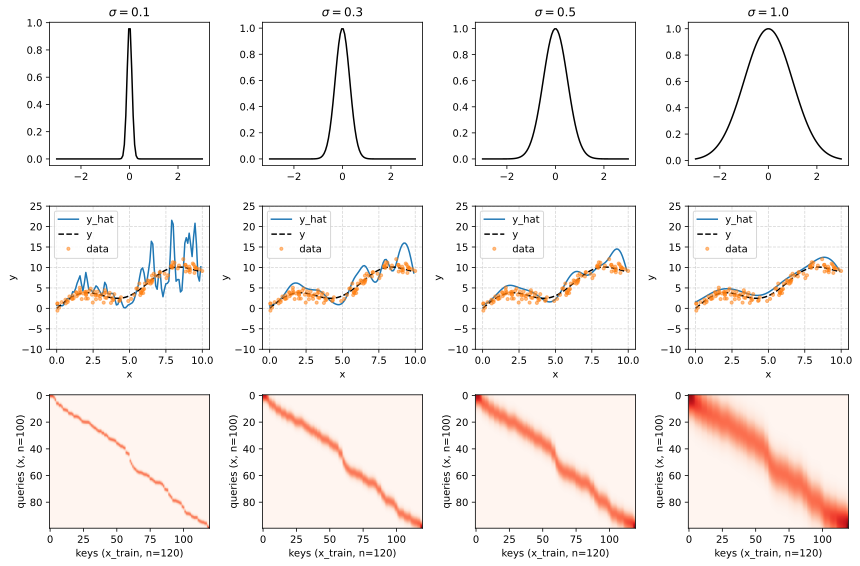

In [4]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8))

for i, sigma in enumerate([0.1, 0.3, 0.5, 1.0]):
    y_hat, attn_weights = attention_pooling(x_train, y_train, x, sigma=sigma)
    t = torch.linspace(-3, 3, 100)
    ax[0, i].plot(t, gaussian(t, sigma), color="k")
    ax[0, i].set_title(r"$\sigma =$" + f"{sigma:.1f}")
    ax[1, i].plot(x, y_hat, label="y_hat")
    ax[1, i].plot(x, y, 'k--', label="y")
    ax[1, i].plot(x_train, y_train, 'o', markersize=3.1, alpha=0.5, label="data")
    ax[1, i].set_xlabel("x")
    ax[1, i].set_ylabel("y")
    ax[1, i].set_ylim(-10, 25)
    ax[1, i].legend()
    ax[1, i].grid(linestyle="dashed", alpha=0.5)
    ax[2, i].imshow(attn_weights.detach().numpy(), cmap='Reds')
    ax[2, i].set_ylabel(f"queries (x, n={len(x)})")
    ax[2, i].set_xlabel(f"keys (x_train, n={len(x_train)})");

fig.tight_layout()

**Figure.** Gaussian kernel width is controlled by the $\sigma$ parameter. The narrower the kernel, the less smooth the estimate becomes. At the same time, it adapts better to local variations. In the context of attention, the width of the kernel essentially increases or decreases the points in the dataset that a test query "attends" to as shown in the attention weights plot.

## Scaled dot product attention

Attention mechanisms differ in terms of what queries they use, how the key and value vectors are defined, and what score function is used. In this section,
we describe the **scaled dot product attention** (SDPA). The goal of this attention mechanism is that any element in a sequence can attend to unmasked elements of the other sequence while still being efficient to compute:

$$
\operatorname{Attention}(\boldsymbol{\mathsf{Q}}, \boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}})
=\operatorname{Softmax}\left(\frac{\boldsymbol{\mathsf{Q}} \boldsymbol{\mathsf{K}^\top}}{\sqrt{d}} + \boldsymbol{\mathsf{M}}\right) \boldsymbol{\mathsf{V}}.
$$

Here $\boldsymbol{\mathsf{Q}}$ and $\boldsymbol{\mathsf{K}}$ are 
$T_q \times d$ and $T_k \times d$ matrices
with rows of query and key vectors usually obtained as linear transformations of the sequence embeddings $\boldsymbol{\mathsf{X}} = (\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{T_k})$ and $\boldsymbol{\mathsf{Y}} = (\boldsymbol{\mathsf{y}}_1, \ldots, \boldsymbol{\mathsf{y}}_{T_q}).$ The value matrix $\boldsymbol{\mathsf{V}}$ is $T_k \times d_v$ and contains rows of value vectors 
that are usually obtained as linear transformations of vectors in $\boldsymbol{\mathsf{X}}$ corresponding to the keys.
The matrix
$\boldsymbol{\mathsf{M}}$, called the **attention mask**, is $T_q \times T_k$ with entries either $0$ or $-\infty$. The factor $\sqrt{d}$ is there so that variance ~ 1. 
The final output is then $T_q \times d_v$  which corresponds to one value vector per query. 
Note that the batch dimension is supressed for simplicity. Observe that computation is efficient regardless of context sizes $T_q$ and $T_k$ since it involves only matrix operations. 

**Self-attention.** The important case where ${\mathsf{X}} = {\mathsf{Y}}$ is called **self-attention**. Here any sequence element can attend to itself. The attention score has shape $T \times T$, where $T = T_q = T_k.$ This can be masked depending on the implementation, e.g. to prevent data leakage. 
For example, in **causal self-attention**, $\boldsymbol{\mathsf{M}}_{ij} = -\infty$ precisely when $j > i$ so that a query cannot look at future keys.
Finally, the computation is asymmetric, the score $\boldsymbol{\mathsf{q}} \cdot \boldsymbol{\mathsf{k}}$ for the same input vector $\boldsymbol{\mathsf{x}}$ need not be 1 (i.e. $\boldsymbol{\mathsf{x}}$ is not looking for itself).

**Masking.** Note that the attention weights has shape $T_q \times T_k$ which corresponds to communication between any two query-key pair. 
Since $\exp(-\infty) = 0$, this means that the weights are computed over the unmasked attention scores. 
Hence, an attention mask nullifies any communication between two pairs of inputs.
In our implementation, we use indicators to mask attention scores instead of adding a tensor `M`:

In [58]:
T = 3
mask = torch.tril(torch.ones(T, T))  # causal
attn_score = torch.randn(3, 3)
print("Mask (indicators)\n", mask, "\n")
print("Attention scores\n", attn_score, "\n")
print("Masked attention scores\n", attn_score.masked_fill(mask == 0, -torch.inf))

Mask (indicators)
 tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]) 

Attention scores
 tensor([[ 0.6714,  0.4307, -0.8635],
        [ 0.9768, -1.3809, -0.8920],
        [ 0.1602, -0.7982, -1.4621]]) 

Masked attention scores
 tensor([[ 0.6714,    -inf,    -inf],
        [ 0.9768, -1.3809,    -inf],
        [ 0.1602, -0.7982, -1.4621]])


In [6]:
pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

PyTorch implementation of SDPA:

In [59]:
def scaled_dot_product(q, k, v, mask=None):
    d = q.shape[-1]
    attn_score = torch.einsum("ik, jk -> ij", q, k)
    attn_score = attn_score / math.sqrt(d)
    if mask is not None:
        assert mask.shape == attn_score.shape
        attn_score = attn_score.masked_fill(mask == 0, -torch.inf)
    
    attention = F.softmax(attn_score, dim=-1)
    values = torch.einsum("ik, kj -> ij", attention, v)
    return values, attention

Example computation of causal self-attention:

In [60]:
T, d, v = 3, 2, 4
q = torch.randn(T, d)
k = torch.randn(T, d)
v = torch.randn(T, v)
output, attention = scaled_dot_product(q, k, v, mask)

print("Q\n", q, "\n")
print("K\n", k, "\n")
print("V\n", v, "\n")
print("Attention\n", attention, "\n")
print("Output\n", output, "\n")

Q
 tensor([[-0.2372,  1.0612],
        [ 1.3619, -1.0850],
        [ 1.1072,  0.8369]]) 

K
 tensor([[ 0.1436,  0.6649],
        [ 0.1353,  0.1635],
        [-0.1028, -0.8632]]) 

V
 tensor([[-0.5117, -1.5211, -1.3205, -1.0645],
        [-0.5527, -0.8982, -1.2549, -0.0612],
        [ 0.5054, -0.9999,  0.4219, -1.7053]]) 

Attention
 tensor([[1.0000, 0.0000, 0.0000],
        [0.4069, 0.5931, 0.0000],
        [0.4826, 0.3564, 0.1611]]) 

Output
 tensor([[-0.5117, -1.5211, -1.3205, -1.0645],
        [-0.5360, -1.1517, -1.2816, -0.4695],
        [-0.3625, -1.2152, -1.0164, -0.8102]]) 



The output vectors are obtained as convex combination of attention weights and value vectors:

In [61]:
0.1303 * v[0] + 0.4630 * v[1] + 0.4067 * v[2]

tensor([-0.1170, -1.0207, -0.5815, -0.8606])

The first vector only attends to itself, so the value vector is unchanged.

<br>

**Remark.** PyTorch has an [efficient implementation](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) of SDPA similar to what we have above:

In [62]:
# WARNING: Expects boolean mask! if float, additive implementation, i.e. +M
F.scaled_dot_product_attention(q, k, v, mask.bool())

tensor([[-0.5117, -1.5211, -1.3205, -1.0645],
        [-0.5360, -1.1517, -1.2816, -0.4695],
        [-0.3625, -1.2152, -1.0164, -0.8102]])

This is so much faster and more stable compared to our implementation:

In [63]:
%%timeit -n 1000
# einsum is slow (see https://github.com/pytorch/pytorch/issues/32591)
# but F.scaled_dot_product_attention still beats permute and @ by 20% relative
scaled_dot_product(q, k, v, mask)

47.1 µs ± 2.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [64]:
%%timeit -n 1000
F.scaled_dot_product_attention(q, k, v, mask.bool())

16.4 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Multi-head attention (MHA)

Given the same set of queries, keys, and values we may want our model to combine knowledge from different behaviors of the same attention mechanism, such as capturing dependencies of various ranges (shorter range vs. longer range, or different word senses). 
Hence, we extend the attention mechanism to have **multiple heads**, i.e. $(\boldsymbol{\mathsf{Q}}_i, \boldsymbol{\mathsf{K}}_i, \boldsymbol{\mathsf{V}}_i)$ triples for $i = 1, \ldots, H$, on the same inputs. 
This is similar to convolutions where we learn multiple feature detectors in parallel. We will assume $d = d_v = d_\text{model}.$ Let $\boldsymbol{\mathsf{Q}} \in \mathbb{R}^{T_q \times d_\text{model}}$ and $\boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}} \in \mathbb{R}^{T_k \times d_{\text{model}}}$, then:

$$\begin{aligned}
\operatorname{MultiheadAttention}(\boldsymbol{\mathsf{Q}}, \boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}})
&= \bigoplus_{i=1}^H\left[\text{Attention}(\boldsymbol{\mathsf{Q}} \boldsymbol{\mathsf{W}}_i^\mathsf{Q}, \boldsymbol{\mathsf{K}} \boldsymbol{\mathsf{W}}_i^\mathsf{K}, \boldsymbol{\mathsf{V}} \boldsymbol{\mathsf{W}}_i^\mathsf{V})\right]\, \boldsymbol{\mathsf{W}}^\text{out} \\
&\in \mathbb{R}^{T_q \times d_\text{model}}
\end{aligned}$$

where $\boldsymbol{\mathsf{W}}^\text{out} \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}$. Note that the number of heads $H$ must divide $d_\text{model}.$ The biases are usually not included as we do here. The idea is that $\boldsymbol{\mathsf{W}}_i^\mathsf{Q} \in \mathbb{R}^{d_{\text{model}} \times d_h}$ projects the queries $\boldsymbol{\mathsf{Q}}$ onto a lower dimensional subspace of dimension $d_h = d_{\text{model}} / H$, and similarly for keys and values. 
Finally, the lower dimensional grouped values are mixed together at the end. 
Multi-head attention therefore combines knowledge of the same attention pooling via different representation subspaces of queries, keys, and values. The architecture is depicted in {numref}`07-mha`.

**Remark.** To facilitate residuals, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension $d_\text{model}$ following {cite}`attention`. Also, recall that $\boldsymbol{\mathsf{Q}} =  \boldsymbol{\mathsf{X}}\boldsymbol{\mathsf{W}}^\mathsf{Q}.$ Then, these are projected to $\boldsymbol{\mathsf{Q}}_i =  \boldsymbol{\mathsf{Q}}\boldsymbol{\mathsf{W}}_i^\mathsf{Q} = \boldsymbol{\mathsf{X}}\boldsymbol{\mathsf{W}}^\mathsf{Q}\boldsymbol{\mathsf{W}}_i^\mathsf{Q}.$ Hence, it suffices to learn a single fused matrix $\boldsymbol{\mathsf{W}}^\mathsf{Q}$ where we calculate $\boldsymbol{\mathsf{Q}}_i$ as an $h$-sized slice of $\boldsymbol{\mathsf{Q}} = \boldsymbol{\mathsf{X}}\boldsymbol{\mathsf{W}}^\mathsf{Q}.$ Similarly for the keys and queries. This is what we will do in the implementation below, where we calculate MHA in parallel in a single pass after carefully indexing the $\boldsymbol{\mathsf{Q}}, \boldsymbol{\mathsf{K}}, \boldsymbol{\mathsf{V}}$ tensors.

```{figure} ../../img/nn/07-mha.png
---
name: 07-mha
width: 300px
---
Multi-head attention. Source: {cite}`attention`
```

In [138]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        assert d_model % num_heads == 0, "No. of heads divides d_model."
        self.d_model = d_model
        self.n_heads = num_heads
        self.d_head = d_model // num_heads

        # Stack all weight matrices 1...H together for efficiency
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, query, key, value, mask=None, return_attention=False):
        """
        Queries, keys, and values are expected to have shapes (B, T, d_model).
        Two types of masks are supported. A boolean mask where a value of True 
        indicates that the element should take part in attention. A float mask of 
        the same type as query, key, value that is added to the attention score.
        """
        if mask is not None:
            mask = self.expand_mask(mask)

        q = self.w_q(query)     # (B, Tq, d_model) -> (B, Tq, d_model)
        k = self.w_k(key)       # (B, Tk, d_model) -> (B, Tk, d_model)
        v = self.w_v(value)     # (B, Tk, d_model) -> (B, Tk, d_model)

        # (B, T, d_model) -> (B, T, H, d_head) -> (B, H, T, d_head)
        assert q.shape[0] == k.shape[0] == v.shape[0]
        assert k.shape[1] == v.shape[1]
        B  = q.shape[0]
        Tq = q.shape[1]
        Tk = k.shape[1]
        q = q.view(B, Tq, self.n_heads, self.d_head).transpose(1, 2)
        k = k.view(B, Tk, self.n_heads, self.d_head).transpose(1, 2)
        v = v.view(B, Tk, self.n_heads, self.d_head).transpose(1, 2)
        
        # Determine value outputs
        o_head = F.scaled_dot_product_attention(q, k, v, mask)
        o_head = o_head.permute(0, 2, 1, 3)            # (B, H, Tq, d_head) -> (B, Tq, H, d_head)
        o_head = o_head.reshape(B, Tq, self.d_model)   # (B, Tq, H, d_head) -> (B, Tq, d_model)
        out = self.w_o(o_head)
        
        if return_attention:
            attn_score = q @ k.transpose(-2, -1) / math.sqrt(self.d_head)
            if mask is not None:
                if mask.dtype == torch.bool:
                    attn_score = attn_score.masked_fill(mask == 0, -torch.inf)
                elif mask.dtype == query.dtype:
                    attn_score += mask
                else:
                    raise ValueError("Mask expected boolean or float with same type as QKV.")
            attn_weight = F.softmax(attn_score, dim=-1)
            return out, attn_weight
        else:
            return out
    
    @staticmethod
    def expand_mask(mask):
        """
        Helper function to support different mask shapes.
        Output shape: (B, H, Tq, Tk)
        If 2D: broadcasted over batch and heads dim
        If 3D: broadcasted over heads dim
        If 4D: leave as is
        """
        assert 2 <= mask.ndim <= 4, "Mask must be at least 2-dimensional with shape (Tq, Tk)"
        if mask.ndim == 2:
            return mask.unsqueeze(0).unsqueeze(0)
        if mask.ndim == 3:
            return mask.unsqueeze(1)
        if mask.ndim == 4:
            return mask

Checking the expected shapes:

In [182]:
mha = MultiheadAttention(d_model=512, num_heads=8)

x = torch.randn(32, 10, 512)    # Tk = 10
y = torch.randn(32, 20, 512)    # Tq = 20
mask = torch.tril(torch.ones(20, 10)).bool()
out, attn = mha(query=y, key=x, value=x, mask=mask, return_attention=True)
out.shape, attn.shape   # expected: (B, Tq, d_model) & (B, H, Tq, Tk)

(torch.Size([32, 20, 512]), torch.Size([32, 8, 20, 10]))

Checking code correctness:

In [186]:
# validating the code inside MHA
q = mha.w_q(y).view(32, 20, 8, 64).transpose(1, 2)
k = mha.w_k(x).view(32, 10, 8, 64).transpose(1, 2)
v = mha.w_v(x).view(32, 10, 8, 64).transpose(1, 2)
o_head = F.scaled_dot_product_attention(q, k, v, mask)

# batch idx = 0, head idx = 0
attn_score = q[0][0] @ k[0][0].transpose(-2, -1) / 8
attn_score = attn_score.masked_fill_(mask == 0, -torch.inf)
print(torch.abs(o_head[0][0] - F.softmax(attn_score, dim=-1) @ v[0][0]).mean())

# entire output
attn_score = q @ k.transpose(-2, -1) / 8
attn_score = attn_score.masked_fill_(mask == 0, -torch.inf)
attn_weight = F.softmax(attn_score, dim=-1)
o = mha.w_o((attn_weight @ v).permute(0, 2, 1, 3).reshape(32, 20, 512))
print(torch.abs(o - out).mean())

# attention weight
print(torch.abs(attn_weight - attn).mean())

tensor(1.1603e-08, grad_fn=<MeanBackward0>)
tensor(1.9958e-08, grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)


## Transformer architecture

Note that the attention layer is low-rank, it has at most rank $d.$

Next, we will look at how to apply the multi-head attention block inside the Transformer architecture. Originally, the Transformer model was designed for machine translation. Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. On the other hand, the decoder attends over the encoded information and generates the translated sentence in an autoregressive manner, as in a standard RNN. While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of autoregressive decoding, we will focus here on the encoder part. 

The encoder consists of $N$ identical blocks that are applied in sequence. Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above. The output is added to the original input using a residual connection, and we apply a consecutive Layer Normalization on the sum. Overall, it calculates LayerNorm $(x+\operatorname{Multihead}(x, x, x))$ ( $x$ being $Q, K$ and $V$ input to the attention layer). The residual connection is crucial in the Transformer architecture for two reasons:

- Similar to ResNets, Transformers are designed to be very deep. Some models contain more than 24 blocks in the encoder. Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.

- Without the residual connection, the information about the original sequence is lost. Remember that the Multi-Head Attention layer ignores the position of elements in a sequence, and can only learn it based on the input features. Removing the residual connections would mean that this information is lost after the first attention layer (after initialization), and with a randomly initialized query and key vector, the output vectors for position 
 has no relation to its original input. All outputs of the attention are likely to represent similar/same information, and there is no chance for the model to distinguish which information came from which input element. An alternative option to residual connection would be to fix at least one head to focus on its original input, but this is very inefficient and does not have the benefit of the improved gradient flow.



The Layer Normalization also plays an important role in the Transformer architecture as it enables faster training and provides small regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence. We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language as the features of words tend to have a much higher variance (there are many, very rare words which need to be considered for a good distribution estimate).

Additionally to the Multi-Head Attention, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. Specifically, the model uses a Linear -> ReLU -> Linear MLP. The full transformation including the residual connection can be expressed as:


$$ \begin{aligned}
\operatorname{FFN}(x) & =\max \left(0, x W_1+b_1\right) W_2+b_2 \\
x & =\text { LayerNorm }(x+\operatorname{FFN}(x))
\end{aligned} $$

This MLP adds extra complexity to the model and allows transformations on each sequence element separately. You can imagine as this allows the model to “post-process” the new information added by the previous Multi-Head Attention, and prepare it for the next attention block. Usually, the inner dimensionality of the MLP is 2-8x
 larger than $d_\text{model}$
, i.e. the dimensionality of the original input $x$. The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.


In [15]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x


Based on this block, we can implement a module for the full Transformer encoder. Additionally to a forward function that iterates through the sequence of encoder blocks, we also provide a function called get_attention_maps. The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder. This helps us in understanding, and in a sense, explaining the model. However, the attention probabilities should be interpreted with a grain of salt as it does not necessarily reflect the true interpretation of the model (there is a series of papers about this, including Attention is not Explanation and Attention is not not Explanation).

In [16]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps


**Remark.** One crucial characteristic of the multi-head attention is that it is permutation-equivariant with respect to its inputs. This means that if we switch any two elements in the source sequence or target sequence, the output is exactly the same besides the elements switched. Hence, MHA is actually looking at the input not as a sequence, but as a set of elements. This property MHA and hence the Transformer architecture powerful and widely applicable! But what if the order of the input is actually important for solving the task, like language modeling? The answer is to encode the position in the input features, which we will take a closer look at in the next section.

## Positional encoding
We have discussed before that the Multi-Head Attention block is permutation-equivariant, and cannot distinguish whether an input comes before another one in the sequence or not. In tasks like language understanding, however, the position is important for interpreting the input words. The position information can therefore be added via the input features. We could learn a embedding for every possible position, but this would not generalize to a dynamical input sequence length. Hence, the better option is to use feature patterns that the network can identify from the features and potentially generalize to larger sequences. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies, as follows:
$$
P E_{(p o s, i)}= \begin{cases}\sin \left(\frac{p o s}{\left.10000^{i / d_{\text {model }}}\right)}\right) & \text { if } i \bmod 2=0 \\ \cos \left(\frac{p o s}{10000^{(i-1) / d_{\text {model }}}}\right) & \text { otherwise }\end{cases}
$$
$P E_{(p o s, i)}$ represents the position encoding at position pos in the sequence, and hidden dimensionality $i$. These values, concatenated for all hidden dimensions, are added to the original input features (in the Transformer visualization above, see "Positional encoding"), and constitute the position information. We distinguish between even $(i \bmod 2=0)$ and uneven ( $i \bmod 2=1$ ) hidden dimensionalities where we apply a sine/cosine respectively. The intuition behind this encoding is that you can represent $P E_{(p o s+k,:)}$ as a linear function of $P E_{(p o s,:)}$, which might allow the model to easily attend to relative positions. The wavelengths in different dimensions range from $2 \pi$ to $10000 \cdot 2 \pi$.

The positional encoding is implemented below. The code is taken from the PyTorch tutorial about Transformers on NLP and adjusted for our purposes.

In [17]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

To understand the positional encoding, we can visualize it below. We will generate an image of the positional encoding over hidden dimensionality and position in a sequence. Each pixel, therefore, represents the change of the input feature we perform to encode the specific position. Let’s do it below.



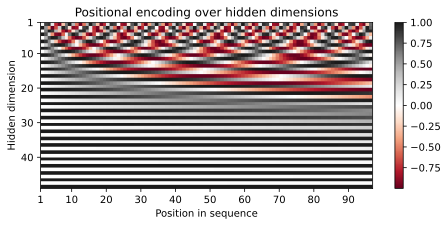

In [18]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

You can clearly see the sine and cosine waves with different wavelengths that encode the position in the hidden dimensions. Specifically, we can look at the sine/cosine wave for each hidden dimension separately, to get a better intuition of the pattern. Below we visualize the positional encoding for the hidden dimensions 
1, 
2, 
 and 
3.

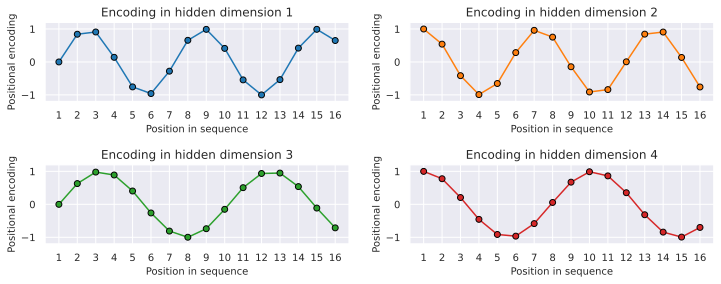

In [19]:
import seaborn as sns
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()


As we can see, the patterns between the hidden dimension 1 and 2 only differ in the starting angle. The wavelength is $2 \pi$, hence the repetition after position 6 . The hidden dimensions 2 and 3 have about twice the wavelength.

---

■